In [34]:
from keras.preprocessing.image import ImageDataGenerator 
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.applications import VGG16
import numpy as np
import keras.backend as Keras
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale= 1)


In [8]:
Keras.clear_session()

In [17]:
# Creamos los generadores de imagenes de entrenamiento, validación y prueba

train_datagen = ImageDataGenerator(
    rescale= 1./ 255, # Reescalamos los pixeles con valores entre 0 y 1 
    shear_range= 0.2,  
    zoom_range= 0.2,        
    horizontal_flip= True
) 

datagen = ImageDataGenerator(rescale= 1./ 255)

train_generator = train_datagen.flow_from_directory(
    directory= '../input/imagenes/train/',
    target_size= (150, 150),
    color_mode= "rgb", # 3 canales 
    batch_size= 32,
    class_mode= "categorical" # one-hot encoded
)

valid_generator = datagen.flow_from_directory(
    directory= '../input/imagenes/val/',
    target_size= (150, 150),
    color_mode= "rgb",
    batch_size= 32,
    class_mode= "categorical"
)

test_generator = datagen.flow_from_directory(
    directory= '../input/imagenes/test/',
    target_size= (150, 150),
    color_mode= "rgb",
    batch_size= 30,
    class_mode= "categorical",
    shuffle= False
)

# Parámetros 
STEP_SIZE_TRAIN= train_generator.n // train_generator.batch_size # Número de pasos que ejecutaremos para entrenar
STEP_SIZE_VALID= valid_generator.n // valid_generator.batch_size # Número de pasos que ejecutaremos para validar
STEP_SIZE_TEST= test_generator.n // test_generator.batch_size # Número de pasos que ejecutaremos para pruebas
NUM_CLASSES = train_generator.num_classes # Número de clases totales para la clasificación

Found 11224 images belonging to 6 classes.
Found 2810 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


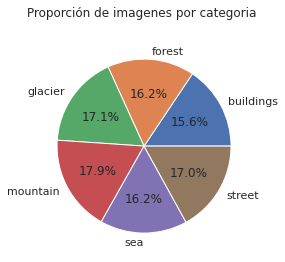

In [4]:
# Analizamos el porcentaje de imagenes de cada categoria

train_images_per_class = np.unique(train_generator.classes, return_counts= True) 

plt.pie(train_images_per_class[1],
        labels= train_generator.class_indices.keys(),
        autopct= '%1.1f%%')

plt.title('Proporción de imagenes por categoria \n')
plt.show()

In [19]:
# Cargamos el modelo VGG16 sin la capa de salida

pre_trained_model = VGG16(input_shape= (150, 150, 3), 
                          include_top = False, # No incluimos el bloque de salida
                          weights = 'imagenet') # Incluimos los valores de los pesos de ImageNet (1000 clases)

for layer in pre_trained_model.layers:
  layer.trainable = False # No entrenamos las capas del modelo

# Creamos el modelo agregando la capa de salida personalizada

model= Sequential()
model.add(pre_trained_model)

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation= 'softmax'))

model.compile(optimizer= Nadam(lr= 0.0001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 1542      
Total params: 16,813,638
Trainable params: 2,098,950
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
# Entrenamiento del modelo

Model = model.fit(train_generator,
        steps_per_epoch= STEP_SIZE_TRAIN,
        validation_data= valid_generator,
        validation_steps= STEP_SIZE_VALID,
        epochs= 15
)

Epoch 1/15
350/350 [==============================] - 98s 279ms/step - loss: 0.6751 - accuracy: 0.7483 - val_loss: 0.4000 - val_accuracy: 0.8588
Epoch 2/15
350/350 [==============================] - 97s 277ms/step - loss: 0.4510 - accuracy: 0.8371 - val_loss: 0.3726 - val_accuracy: 0.8649
Epoch 3/15
350/350 [==============================] - 96s 275ms/step - loss: 0.4018 - accuracy: 0.8526 - val_loss: 0.3643 - val_accuracy: 0.8696
Epoch 4/15
350/350 [==============================] - 98s 280ms/step - loss: 0.3689 - accuracy: 0.8659 - val_loss: 0.3214 - val_accuracy: 0.8786
Epoch 5/15
350/350 [==============================] - 92s 264ms/step - loss: 0.3556 - accuracy: 0.8714 - val_loss: 0.3254 - val_accuracy: 0.8818
Epoch 6/15
350/350 [==============================] - 93s 265ms/step - loss: 0.3331 - accuracy: 0.8800 - val_loss: 0.3333 - val_accuracy: 0.8768
Epoch 7/15
350/350 [==============================] - 95s 271ms/step - loss: 0.3194 - accuracy: 0.8835 - val_loss: 0.3123 - val_ac

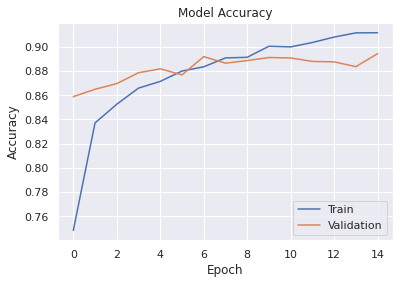

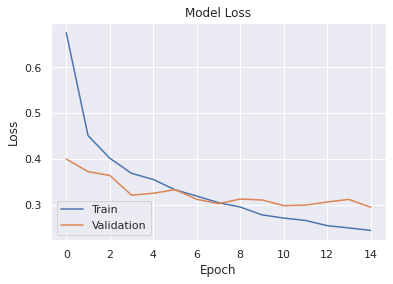

In [21]:
# Creamos dos gráficas y comparamos la exactitud y la pérdida con respecto a los datos de entrenamiento y validación

# Gráfica accuracy

plt.plot(Model.history['accuracy'])
plt.plot(Model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Gráfica loss

plt.plot(Model.history['loss'])
plt.plot(Model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower left')
plt.show()

In [24]:
# Guardamos el modelo entrenado

model.save('/kaggle/working/ModeloIII(VGG16-TL).h5')

In [25]:
# Cargamos el modelo

modelLoad = keras.models.load_model('/kaggle/working/ModeloIII(VGG16-TL).h5')

In [26]:
# Evaluamos el modelo con los datos de prueba

results = modelLoad.evaluate(test_generator, steps= STEP_SIZE_TEST)
print("Loss: {} Accuracy: {}".format(results[0], results[1] * 100))

100/100 [==============================] - 5s 53ms/step - loss: 0.3045 - accuracy: 0.8867
Loss: 0.30445656180381775 Accuracy: 88.66666555404663


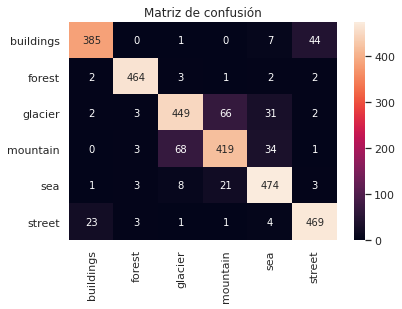

In [27]:
# Analizamos las predicciones de los datos de pruebas

predictions = modelLoad.predict(test_generator) # Vector de probabilidades
pred_labels = np.argmax(predictions, axis = 1) # Obtenemos la predicción con mas probabilidad
class_names = test_generator.class_indices.keys() # Nombre de las etiquetas

CM = confusion_matrix(test_generator.classes, pred_labels) # Matriz de confusión

ax = plt.axes()
sn.heatmap(CM, annot= True, 
           annot_kws={"size": 10}, 
           xticklabels= class_names, 
           yticklabels= class_names, 
           ax = ax,
           fmt= "d")
ax.set_title('Matriz de confusión')
plt.show()

In [28]:
# Función para obtener la etiqueta

def getcode(n) : 
    for x , y in train_generator.class_indices.items() : 
        if n == y : 
            return x 

In [32]:
# Usamos el modelo para predecir una imagen en concreto

img = image.load_img('../input/imagenes/test/forest/20056.jpg', target_size = (150, 150))
img = image.img_to_array(img)
img = np.expand_dims(img, axis = 0)

predict = modelLoad.predict(img)
print('Predicción de la imagen: ' + getcode(np.argmax(predict)))

Predicción de la imagen: forest
